In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
path = 'Reorgnized_RB.csv'
Russell_data = pd.read_csv(path)

# Feature engineering

In [150]:
from math import sqrt

# All of the features of interest
selected_inputs = [
    "Min",
    "FGM",
    "FGA",
    "FG%",
    "3PM",
    "3PA",
    "3P%",
    "FTM",
    "FTA",
    "FT%",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PF",
    #"+/-",
    "Year",
    "Team score",
    "Season",
    'Lose',
    'Win',
    'Friday',
    'Monday',
    'Saturday',
    'Sunday',
    'Thursday',
    'Tuesday',
    'Wednesday',
    'HOU',
    'LAC',
    'LAL',
    'OKC',
    'WAS',
    'Playoff',
    'Regular'
]


all_features = []
for feature_name in selected_inputs:
    
    squared_feature_name = feature_name + '_square'
    sqrt_feature_name = feature_name + '_sqrt'
    
    # compute the square of the column feature_name, add it to performance as a 
    # new column, squared_feature_name
    Russell_data[squared_feature_name] = Russell_data[feature_name] ** 2
    
    # compute the sqrt of the column feature_name, add it to performance as a
    # new column, sqrt_feature_name
    Russell_data[sqrt_feature_name] = Russell_data[feature_name] ** 0.5

    # Add the feature names to all_features
    all_features.extend([feature_name, squared_feature_name, sqrt_feature_name])
    
# Split the data into features and score
score = Russell_data["PTS"]
performance = Russell_data[all_features]

performance.head()

,Min,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,...,Thursday,Tuesday,Wednesday,HOU,LAC,LAL,OKC,WAS,Playoff,Regular
0,22.0,4.0,9.0,44.4,1.0,2.0,50.0,4.0,6.0,66.7,...,0,0,1,0,0,0,1,0,0,1
1,19.0,2.0,7.0,28.6,0.0,1.0,0.0,2.0,2.0,100.0,...,0,0,0,0,0,0,1,0,0,1
2,25.0,6.0,13.0,46.2,0.0,1.0,0.0,2.0,3.0,66.7,...,0,0,0,0,0,0,1,0,0,1
3,19.0,4.0,13.0,30.8,3.0,5.0,60.0,2.0,2.0,100.0,...,0,0,1,0,0,0,1,0,0,1
4,17.0,1.0,8.0,12.5,0.0,0.0,0.0,4.0,4.0,100.0,...,0,0,0,0,0,0,1,0,0,1


In [151]:
nan_values = performance.isnull().sum().sum()
print(f"The DataFrame contains {nan_values} NaN values.")

# Check for infinity
inf_values = np.isinf(performance.values).sum()
print(f"The DataFrame contains {inf_values} infinite values.")

# Check for values too large for float64
# Note: This is a bit tricky because "too large" depends on the context and the scale of your data.
# float64 can represent numbers as large as ~1.8e308, which is usually large enough for most datasets.
# If you have domain-specific limits for your data, you should check against those.
# Here we check for values that are beyond the maximum representable float64 value.
too_large_values = (performance.values > np.finfo(np.float64).max).sum()
print(f"The DataFrame contains {too_large_values} values too large for float64.")

The DataFrame contains 0 NaN values.
The DataFrame contains 0 infinite values.
The DataFrame contains 0 values too large for float64.


# Split data

In [152]:
from sklearn.model_selection import train_test_split

performance_train_data, val_test_data,score_train, score_val_test = train_test_split(performance,score, test_size=0.3)
performance_val_data, performance_test_data, score_val, score_test = train_test_split(val_test_data,score_val_test, test_size= 0.5)

# Standardization

In [153]:
from sklearn.preprocessing import StandardScaler

standardized = StandardScaler().fit(performance_train_data)
performance_train_data_standardized = standardized.transform(performance_train_data)
performance_val_data_standardized = standardized.transform(performance_val_data)
performance_test_data_standardized = standardized.transform(performance_test_data)

# (1)Linear Regerssion

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


model = LinearRegression()
model.fit(performance_train_data_standardized, score_train)
test_predict = model.predict(performance_test_data_standardized)
rmse_test_unregularized = mean_squared_error(score_test, test_predict, squared=False)
print("Test RMSE", rmse_test_unregularized)


Test RMSE 6.107182452508465e-15


# (2) Ridge Regression

In [155]:
from sklearn.linear_model import Ridge

l2_lambdas = np.logspace(-5, 5, 11, base = 10)

ridge_data = []
for i in l2_lambdas:
  ridge_model = Ridge(alpha=i)
  ridge_model.fit(performance_train_data_standardized, score_train)
  predictions_train = ridge_model.predict(performance_train_data_standardized)
  predictions_validation = ridge_model.predict(performance_val_data_standardized)
  ridge_data.append({
        'l2_penalty': i,
        'model':ridge_model,
        'rmse_train':mean_squared_error(predictions_train, score_train, squared=False),
        'rmse_validation':mean_squared_error(predictions_validation, score_val, squared=False)
    })
ridge_data = pd.DataFrame(ridge_data)
ridge_data

,l2_penalty,model,rmse_train,rmse_validation
0,0.00001,Ridge(alpha=1e-05),4.218395e-07,4.569926e-07
1,0.00010,Ridge(alpha=0.0001),4.218374e-06,4.569904e-06
2,0.00100,Ridge(alpha=0.001),4.218166e-05,4.569686e-05
3,0.01000,Ridge(alpha=0.01),4.216089e-04,4.567511e-04
4,0.10000,Ridge(alpha=0.1),4.195443e-03,4.545879e-03
5,1.00000,Ridge(),4.000397e-02,4.341095e-02
6,10.00000,Ridge(alpha=10.0),2.761600e-01,3.028104e-01
7,100.00000,Ridge(alpha=100.0),8.355083e-01,9.470823e-01
8,1000.00000,Ridge(alpha=1000.0),2.713678e+00,2.975536e+00
9,10000.00000,Ridge(alpha=10000.0),6.866140e+00,7.356336e+00


How penalty affects the train and test dataset?

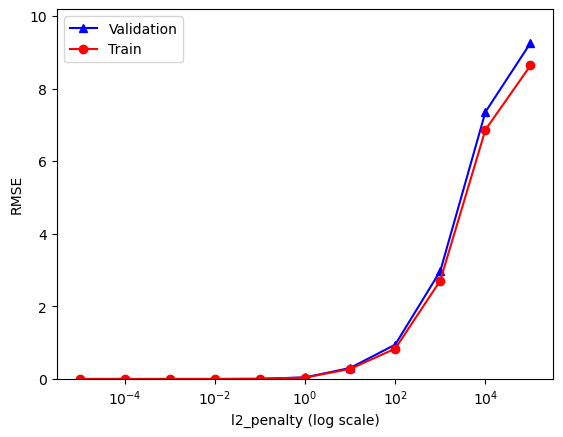

In [156]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['rmse_validation'], 
         'b-^', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['rmse_train'], 
         'r-o', label='Train')

# Set y-limits
rmse_max = max(ridge_data['rmse_train'].max(), ridge_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

In [157]:
def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(features, model.coef_))
    print(*feats, sep = "\n")

In [158]:
# Print information about best l2 model
index = ridge_data['rmse_validation'].idxmin()
row = ridge_data.loc[index]
best_l2 = row['l2_penalty']


ridge_model_test = Ridge(alpha=best_l2)
ridge_model_test.fit(performance_train_data_standardized, score_train)
predictions_test = ridge_model_test.predict(performance_test_data_standardized)
rmse_test_ridge = mean_squared_error(predictions_test, score_test, squared=False)

count = 0
for num in ridge_model_test.coef_:
  if num == 0:
    count += 1
num_zero_coeffs_ridge = count

# Print your results to help you check their correctness.
print('L2 Penalty',  best_l2)
print('Test RSME', rmse_test_ridge)
print('Num Zero Coeffs', num_zero_coeffs_ridge)

L2 Penalty 1e-05
Test RSME 4.817614592397898e-07
Num Zero Coeffs 0


# (3) LASSO Regression

In [159]:
from sklearn.linear_model import Lasso

l1_lambdas = np.logspace(-12, 7, 7, base=10)

# Implement code to evaluate LASSO Regression with various L1 penalties
lasso_data = []
for i in l1_lambdas:
  lasso_model = Lasso(alpha=i)
  lasso_model.fit(performance_train_data_standardized, score_train)
  predictions_train = lasso_model.predict(performance_train_data_standardized)
  predictions_validation = lasso_model.predict(performance_val_data_standardized)
  lasso_data.append({
        'l1_penalty': i,
        'model':lasso_model,
        'rmse_train':mean_squared_error(predictions_train, score_train, squared=False),
        'rmse_validation':mean_squared_error(predictions_validation, score_val, squared=False)
    })
lasso_data = pd.DataFrame(lasso_data)
lasso_data

,l1_penalty,model,rmse_train,rmse_validation
0,1.000000e-12,Lasso(alpha=1e-12),0.005991,0.006293
1,1.467799e-09,Lasso(alpha=1.4677992676220676e-09),0.005991,0.006293
2,2.154435e-06,Lasso(alpha=2.1544346900318822e-06),0.005961,0.006258
3,3.162278e-03,Lasso(alpha=0.0031622776601683794),0.004552,0.005047
4,4.641589e+00,Lasso(alpha=4.641588833612772),5.765785,6.348173
5,6.812921e+03,Lasso(alpha=6812.9206905795945),8.911877,9.552043
6,1.000000e+07,Lasso(alpha=10000000.0),8.911877,9.552043


How the L1 penalty affects the performance

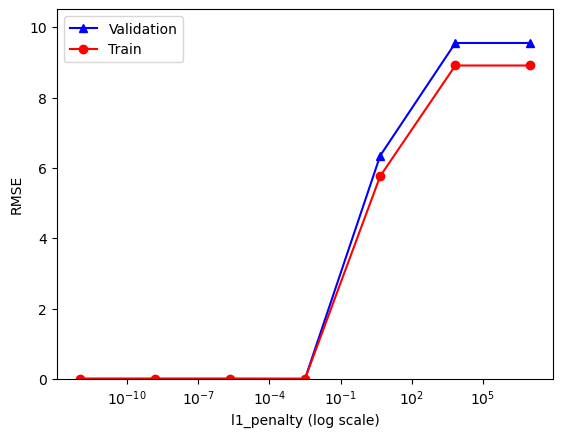

In [160]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_validation'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_train'],
         'r-o', label='Train')

# Set y-limits
rmse_max = max(lasso_data['rmse_train'].max(), lasso_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

In [161]:
# Print information about best L1 model

index = lasso_data['rmse_validation'].idxmin()
row = lasso_data.loc[index]
best_l1 = row['l1_penalty']


lasso_model_test = Lasso(alpha=best_l1)
lasso_model_test.fit(performance_train_data_standardized, score_train)
predictions_test = lasso_model_test.predict(performance_test_data_standardized)
rmse_test_lasso = mean_squared_error(predictions_test, score_test, squared=False)

count = 0
for num in lasso_model_test.coef_:
  if num == 0:
    count += 1
num_zero_coeffs_lasso = count

# Print your results to help you check their correctness.
print('Best L1 Penalty', best_l1)
print('Test RMSE', rmse_test_lasso)
print('Num Zero Coeffs', num_zero_coeffs_lasso)

Best L1 Penalty 0.0031622776601683794
Test RMSE 0.005150050672964629
Num Zero Coeffs 33


Look at which coefficients ended up having a 0 coefficient.

In [162]:
best_model_lasso = lasso_model_test

zero_coef_features = []
nonzero_coef_features = []
for feature, coef in zip(all_features, best_model_lasso.coef_):
  if abs(coef) <= 10 ** -17:
    zero_coef_features.append(feature)
  else:
    nonzero_coef_features.append(feature)

print("Features with coefficient == 0:", zero_coef_features)
print("Features with coefficient != 0:", nonzero_coef_features)

Features with coefficient == 0: ['Min', 'Min_sqrt', 'FGM', 'FGM_sqrt', 'FGA', 'FG%', 'FG%_square', 'FG%_sqrt', '3PM', '3PM_square', '3PM_sqrt', '3PA', '3PA_square', '3PA_sqrt', '3P%', '3P%_square', '3P%_sqrt', 'FTM', 'FTM_square', 'FTM_sqrt', 'FTA', 'FTA_square', 'FTA_sqrt', 'FT%', 'FT%_square', 'FT%_sqrt', 'OREB', 'OREB_square', 'OREB_sqrt', 'DREB', 'DREB_square', 'DREB_sqrt', 'REB']
Features with coefficient != 0: ['Min_square', 'FGM_square', 'FGA_square', 'FGA_sqrt']


In [163]:
def print_coefficients(model, features):
    """
    This function takes in a model and a features column.
    And prints the coefficient along with its feature name.
    """
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef}")

print_coefficients(lasso_model_test, all_features)

Min: 0.0
Min_square: 6.810164944502491
Min_sqrt: 0.0
FGM: 0.0
FGM_square: 1.261023390682978
FGM_sqrt: 0.0
FGA: 0.0
FGA_square: 3.3472358819850596
FGA_sqrt: 2.9490342307841314e-05
FG%: 0.0
FG%_square: 0.0
FG%_sqrt: 0.0
3PM: 0.0
3PM_square: 0.0
3PM_sqrt: 0.0
3PA: -0.0
3PA_square: 0.0
3PA_sqrt: 0.0
3P%: 0.0
3P%_square: 0.0
3P%_sqrt: 0.0
FTM: 0.0
FTM_square: -0.0
FTM_sqrt: 0.0
FTA: -0.0
FTA_square: -0.0
FTA_sqrt: 0.0
FT%: 0.0
FT%_square: -0.0
FT%_sqrt: -0.0
OREB: 0.0
OREB_square: -0.0
OREB_sqrt: -0.0
DREB: 0.0
DREB_square: -0.0
DREB_sqrt: 0.0
REB: -0.0
